In [1]:
import os
import re
import sys
import pandas as pd
import numpy as np
import tensorflow as tf

from IPython.display import display
import matplotlib.pyplot as plt

import custom_modules.PipeData as pidf
from custom_modules import data_processing as dp

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Reshape, Input, Dense, Flatten, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

In [2]:
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/Original data/Run1/run1_WM32_data.csv',
        'data/Original data/Run1/run1_WM32_defects.csv',
        'data/Original data/Run1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/Original data/Run2/run2_WM32_data.csv',
        'data/Original data/Run2/run2_WM32_defects.csv',
        'data/Original data/Run2/run2_WM32_pipe.csv')
}

PATH_TO_MODEL = 'networks/CNN/id=06_in(8x8+8x8)_out(1)_train=0dot000056_test=0dot0.h5'

CROP_SIZE = 8
CROP_STEP = 1

# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(290)

# чтение данных
test_1 = pidf.PipeDataCsvWorker(*PATH_TO_DATA['run_2'])

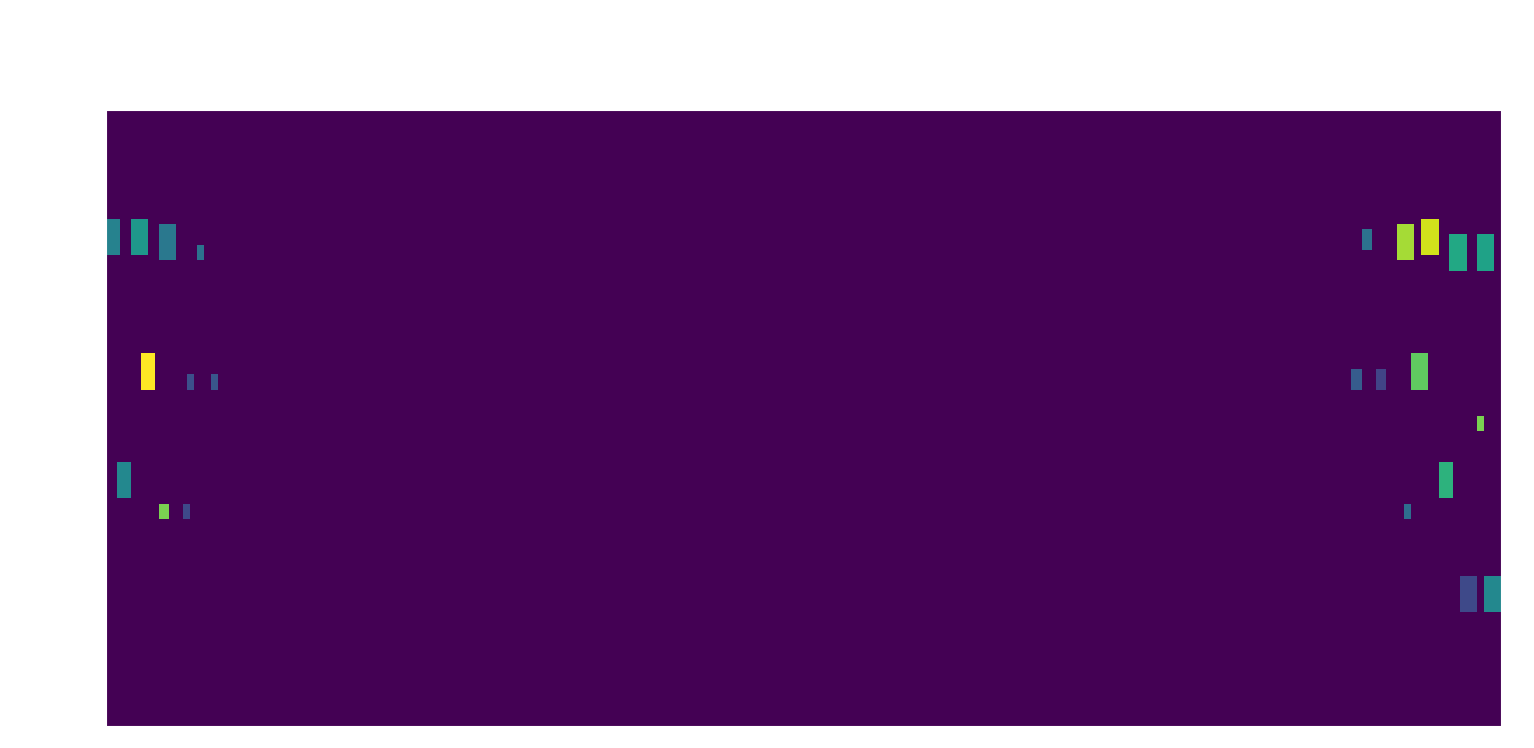

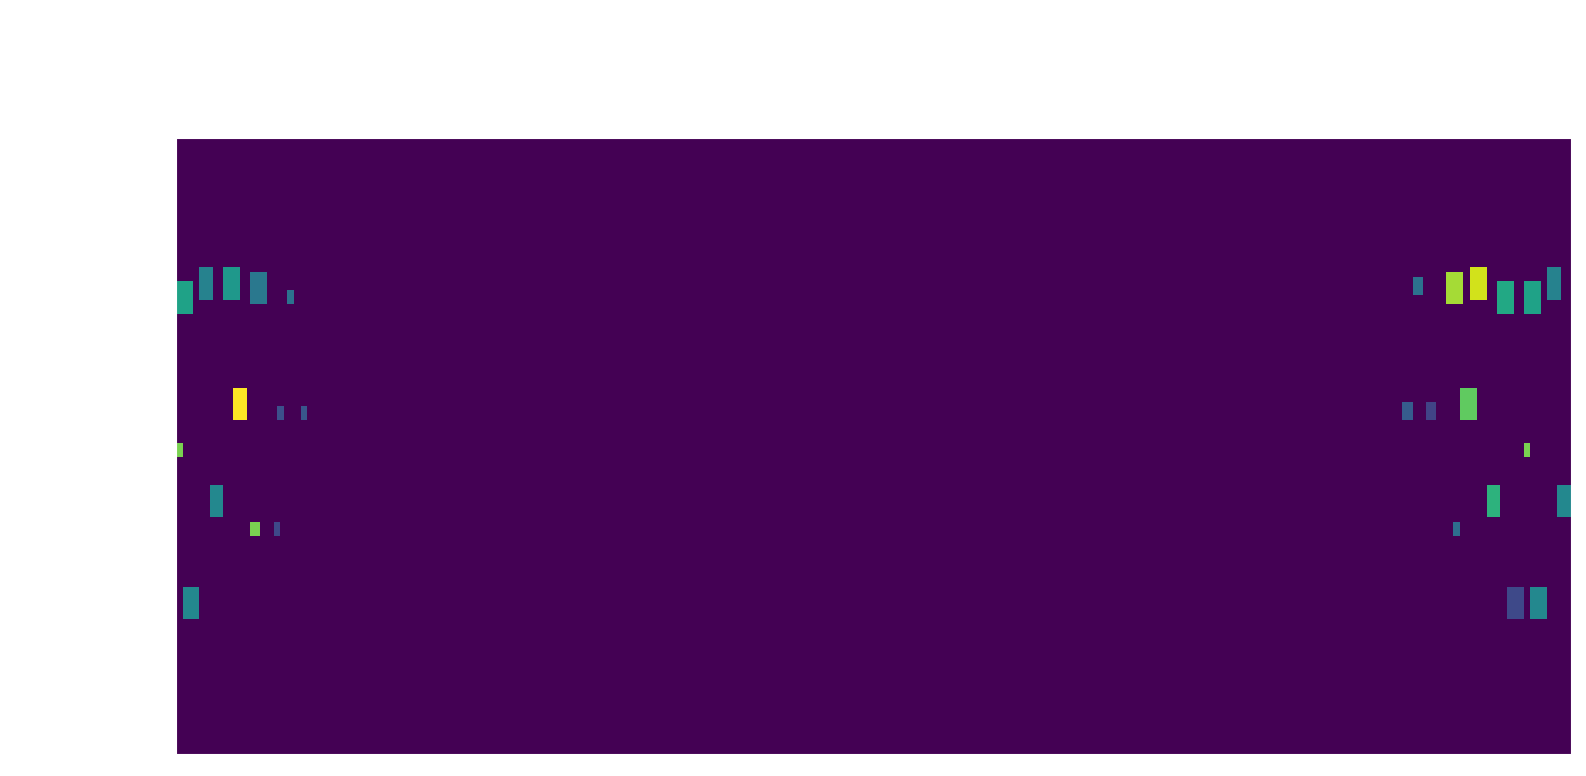

In [3]:
# Вывод считанных данных и их расширение для обучения
test_1.draw_defects_map(title='Считанная развернутая карта дефектов')
test_1.extend_dfs_for_prediction(crop_size=CROP_SIZE, crop_step=CROP_STEP)
test_1.draw_defects_map(title=f'Расширенная развернутая карта дефектов для cr.size: {CROP_SIZE} и cr.step: {CROP_STEP}')

In [4]:
# Забрать данные из класса
x_data = test_1.get_data_df()
y_data = test_1.get_defects_df()
test_1 = None

In [5]:
# преобразовать данные к виду (измерение, размер х, размер у, каналы)
# для x_data_time каналы = 32
# для x_data_amp каналы = 32
# для y_data каналы = 1
(x_data_time,
x_data_amp) = dp.reshape_X_df_to_image_like_numpy(x_data, CROP_SIZE, CROP_STEP)
y_data = dp.reshape_Y_df_to_image_like_numpy(y_data, CROP_SIZE, CROP_STEP)

||||||||||||||||||
X df reshaping to 4D
Original df size:  (133, 414)
Crop windows height/width:  8
Crop windows step across rows and cols:  1
New X_time shape:  (51282, 8, 8, 32)
New X_amp shape:  (51282, 8, 8, 32)
||||||||||||||||||

||||||||||||||||||
Y df reshaping to 3D
Original df size:  (133, 414)
Crop windows height/width:  8
Crop windows step across rows and cols:  1
New numpy shape:  (51282, 8, 8, 1)
||||||||||||||||||



In [6]:
# нормализовать входные данные
x_data_time = dp.standartize_data(x_data_time)
x_data_amp = dp.standartize_data(x_data_amp)

||||||||||||||||||
Data standartizing
arr_max before normalization: 44.4
arr_min before normalization: 0.0
arr_max after normalization: 1.0
arr_min after normalization: 0.0
||||||||||||||||||

||||||||||||||||||
Data standartizing
arr_max before normalization: 62.992
arr_min before normalization: -62.482
arr_max after normalization: 1.0
arr_min after normalization: -0.9919037338074677
||||||||||||||||||



In [7]:
# Аугментировать данные
#x_data_time = dp.augment_data(x_data_time) 
#x_data_amp = dp.augment_data(x_data_amp) 
#y_data = dp.augment_data(y_data) 

In [8]:
# создание выходных данных бинарного вида (одномерный массив типа bool)
y_data = dp.create_binary_arr_from_mask_arr(y_data)

||||||||||||||||||
Y binary arr from Y mask arr creation
Y mask arr shape:  (51282, 8, 8, 1)
Y binary arr shape:  (51282,)
||||||||||||||||||



In [9]:
print(f'{x_data_time.shape=}')
print(f'{x_data_amp.shape=}')
print(f'{y_data.shape=}\n')

x_data_time.shape=(51282, 8, 8, 32)
x_data_amp.shape=(51282, 8, 8, 32)
y_data.shape=(51282,)



In [10]:
# загрузка модели
model = keras.models.load_model(PATH_TO_MODEL)

In [11]:
# тест модели
res = model.evaluate([x_data_time, x_data_amp], y_data, batch_size = 32)


1603/1603 [==============================] - 112s 70ms/step - loss: 0.0682


In [12]:
print(res)

0.0682198703289032
